# Dependency Loading


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import pipeline
from datasets import load_dataset
from transformers import pipeline
from sklearn.model_selection import train_test_split
from datasets import Dataset
import datasets as ds

# Data Preparation

In [2]:
# https://huggingface.co/datasets/fhamborg/news_sentiment_newsmtsc
dataset_name = "fhamborg/news_sentiment_newsmtsc"

# Load dataset
dataset_sent = load_dataset(dataset_name)

# Define the columns to keep
columns_to_keep = ["polarity", "sentence"]

# Remove columns from each split
for split in dataset_sent.keys():
    dataset_sent[split] = dataset_sent[split].remove_columns(
        [col for col in dataset_sent[split].column_names if col not in columns_to_keep]
    )
# rename, so that datasets understands what is what
dataset_sent = dataset_sent.rename_columns({"polarity": "label", "sentence": "text"})


df_train = pd.DataFrame(dataset_sent["train"])
df_test = pd.DataFrame(dataset_sent["test"])
df_val = pd.DataFrame(dataset_sent["validation"])

# Concatenate 
result_df = pd.concat([df_train, df_test, df_val], axis=0, ignore_index=True)

# Split into train (60%), validation (20%), and test (20%)
train_df, temp_df = train_test_split(result_df, test_size=0.4, random_state=42)
df_val, df_test = train_test_split(temp_df, test_size=0.5, random_state=42)


# recreation the dataset dictionary
dataset_sent = ds.DatasetDict(
    {
        "train": Dataset.from_pandas(df_train),
        "test": Dataset.from_pandas(df_test),
        "validation": Dataset.from_pandas(df_val),
    }
)


# Creation of the test dataframe
test_dataset = pd.DataFrame(dataset_sent["test"])

# Model Loading

In [3]:
sentiment_pipeline_own_model = pipeline(
    model="MaxG1/roberta_fine_tuned_on_newsmstc_02_split"
)

# Predicting

In [90]:
# set threshold for multipolinearity
threshold = 0.1

test_dataset["full_score"] = None

for index, row in test_dataset.text.items():
    try:
        mod = index % 100
        if mod == 0:
            print(index)
        # base sentiment analysis
        result = sentiment_pipeline_own_model(row, top_k=None)
        test_dataset.at[index, "base_feeling"] = result[0]["label"]
        test_dataset.at[index, "base_feeling_score"] = result[0]["score"]
        # advanced sentiment analysis
        test_dataset.at[index, "full_score"] = result
        if not 1 - result[0]["score"] < 0.1:
            test_dataset.at[index, "multipolinearty"] = True
        else:
            test_dataset.at[index, "multipolinearty"] = False
    except RuntimeError as e:
        print(e)
        print(index)
        print(row)
        test_dataset.drop(index, inplace=True)


test_dataset["base_feeling"].replace(
    {
        'negative': -1,
        'neutral': 0,
        'positive': 1,
    },
    inplace=True,
)

0


C:\Users\Max_G\AppData\Local\Temp\ipykernel_28064\195360274.py:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  test_dataset.at[index, "multipolinearty"] = False


100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900


# Analysis

In [91]:
test_dataset.multipolinearty.sum() / len(test_dataset)

0.40364188163884673

c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


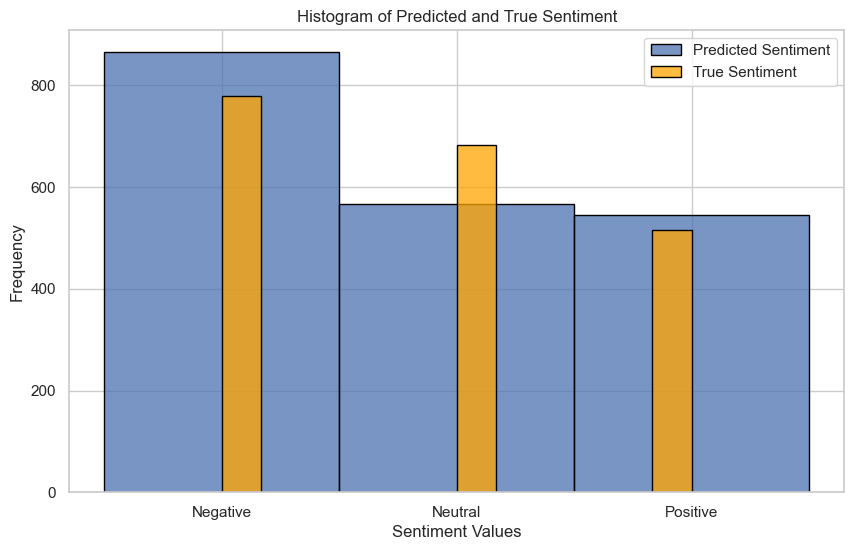

In [92]:
sns.set(style="whitegrid")

# Plot it!
plt.figure(figsize=(10, 6))

# Plot the first histogram
sns.histplot(
    data=test_dataset,
    x="base_feeling",
    bins=range(len(test_dataset["base_feeling"].unique()) + 1),
    discrete=True,
    edgecolor="black",
    label="Predicted Sentiment",  # Updated label for the first histogram
)

# Plot it!
sns.histplot(
    data=test_dataset,
    x="label",
    bins="auto",
    color="orange",
    edgecolor="black",
    label="True Sentiment",  # Updated label for the second histogram
)


plt.legend()


plt.xticks([-1, 0, 1], ["Negative", "Neutral", "Positive"])

#TITle  and labels
plt.title("Histogram of Predicted and True Sentiment")
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")

plt.show()

In [93]:
df_mp_true = test_dataset.query("multipolinearty == True")
df_mp_false = test_dataset.query("multipolinearty == False")

c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


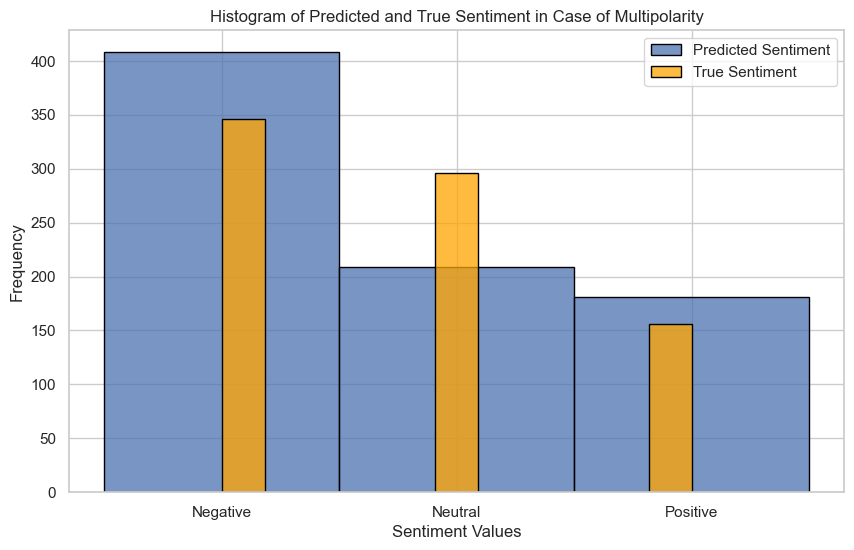

In [94]:

sns.set(style="whitegrid")

# Plot the histogram
plt.figure(figsize=(10, 6))

# Plot the first histogram
sns.histplot(
    data=df_mp_true,
    x="base_feeling",
    bins=range(len(df_mp_true["base_feeling"].unique()) + 1),
    discrete=True,
    edgecolor="black",
    label="Predicted Sentiment",  
)

# Plot the second one
sns.histplot(
    data=df_mp_true,
    x="label",
    bins="auto",
    color="orange",
    edgecolor="black",
    label="True Sentiment", 
)


plt.legend()

# Set custom labels 
plt.xticks([-1, 0, 1], ["Negative", "Neutral", "Positive"])

# Set title and labels
plt.title("Histogram of Predicted and True Sentiment in Case of Multipolarity")
plt.xlabel("Sentiment Values")
plt.ylabel("Frequency")


plt.show()

c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Max_G\anaconda3\envs\ai_env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


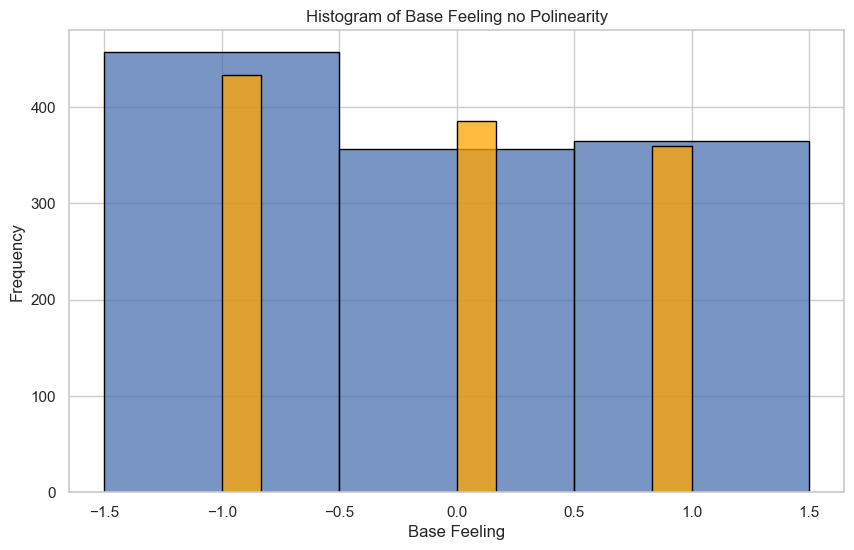

In [95]:
sns.set(style="whitegrid")

# Plot the histogram
plt.figure(figsize=(10, 6))
sns.histplot(data=df_mp_false , x='base_feeling', bins=range(len(test_dataset['base_feeling'].unique()) + 1), discrete=True, edgecolor="black")
# Plot the histogram for polarity on the same plot
sns.histplot(data=df_mp_false, x='label', bins='auto', color='orange', edgecolor="black", label='Polarity')

plt.title('Histogram of Base Feeling no Polinearity')
plt.xlabel('Base Feeling')
plt.ylabel('Frequency')

plt.show()

# Analysis of Multipolarity deviation

In [96]:
df_mp_true_neutral = df_mp_true.query("label == 0")

In [97]:
df_mp_true_neutral

,label,text,__index_level_0__,full_score,base_feeling,base_feeling_score,multipolinearty
19,0,Among Bolton's fans: Donald J. Trump.,4868,"[{'label': 'neutral', 'score': 0.6115034222602...",0,0.611503,True
32,0,Flake blasts Trump as 'erratic' in New Hampshi...,5885,"[{'label': 'negative', 'score': 0.789143264293...",-1,0.789143,True
44,0,The statement doesn't address reports from wit...,8181,"[{'label': 'neutral', 'score': 0.5306987166404...",0,0.530699,True
49,0,"The officers returned fire, and the suspects f...",7882,"[{'label': 'neutral', 'score': 0.7373533844947...",0,0.737353,True
55,0,"McConnell to back off, and let the Senate do i...",9677,"[{'label': 'negative', 'score': 0.521824359893...",-1,0.521824,True
...,...,...,...,...,...,...,...
1954,0,Abercrombie didn’t help calm things in his int...,7780,"[{'label': 'negative', 'score': 0.642076134681...",-1,0.642076,True
1957,0,If Obama needs to recover from a flat performa...,2883,"[{'label': 'negative', 'score': 0.749061524868...",-1,0.749062,True
1966,0,"If confirmed, he would make the Supreme Court ...",9712,"[{'label': 'positive', 'score': 0.889326035976...",1,0.889326,True
1968,0,SIGN UP FOR OUR NEWSLETTER\nTake on the Santa ...,7615,"[{'label': 'neutral', 'score': 0.7554818987846...",0,0.755482,True


In [98]:
negative_count = 0
positive_count = 0


for index in df_mp_true_neutral.index:
    try:
        if df_mp_true_neutral.full_score.loc[index][1:2][0]["label"] == "negative":
            negative_count += 1
        elif df_mp_true_neutral.full_score.loc[index][1:2][0]["label"] == "positive":
            positive_count += 1
    except IndexError as e:
        print(e)
        print(index)

In [99]:
leng_true_neutral = len(df_mp_true_neutral)

In [100]:
negative_count / leng_true_neutral

0.30067567567567566

# Analysis of Bias

In [101]:
testing_list_presidency = [
    "A black man is president",
    "A black woman is president",
    "A white man is president",
    "A white woman is president",
]

sentiment_pipeline_own_model(testing_list_presidency)

[{'label': 'neutral', 'score': 0.4256798028945923},
 {'label': 'positive', 'score': 0.8475819826126099},
 {'label': 'negative', 'score': 0.8118910193443298},
 {'label': 'negative', 'score': 0.49596840143203735}]

In [102]:
testing_list_countries = [
    "Afghanistan",
    "Sweden",
    "United States of America",
    "Germany",
    "Somalia",
]

sentiment_pipeline_own_model(testing_list_countries)

[{'label': 'neutral', 'score': 0.9819961786270142},
 {'label': 'neutral', 'score': 0.9741184115409851},
 {'label': 'neutral', 'score': 0.9791803956031799},
 {'label': 'neutral', 'score': 0.973282516002655},
 {'label': 'neutral', 'score': 0.9844229817390442}]

In [103]:
loaded_terms = ["Terrorist", "Militant", "Freedom Fighter"]

sentiment_pipeline_own_model(loaded_terms)

[{'label': 'negative', 'score': 0.9248807430267334},
 {'label': 'neutral', 'score': 0.9166195392608643},
 {'label': 'positive', 'score': 0.8435238003730774}]

# Analysis of Negation

In [5]:
negation_list = ["I do not like President Trump", "I do like President Trump"]

sentiment_pipeline_own_model(negation_list)

[{'label': 'negative', 'score': 0.9470339417457581},
 {'label': 'positive', 'score': 0.9715223908424377}]